### Bài 1. Clustering 
- Cho dữ liệu bbc (giải nén file bbc-fulltext). Đọc tất cả dữ liệu vào dataframe news theo định dạng id - content - class.
#### Yêu cầu : Chuẩn hóa dữ liệu (nếu cần) và chọn một thuật toán thích hợp để thực hiện việc 
phân cụm dữ liệu dựa trên cột content của dataframe news trên. 
1. Áp dụng thuật toán thích hợp. Dựa trên cơ sở nào để cho rằng thuật toán này thích 
hợp? 
2. Tìm kết quả => có bao nhiêu cụm => mẫu (tin tức) nào thuộc cụm nào? 
3. Nhận xét trên từng cụm: mỗi cụm có những keywords nào ? Vẽ WordClouds cho từng 
cụm. 
4. Kiểm chứng lại với class đã có

In [10]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import os
import seaborn as sns
import re
from string import punctuation
import nltk.corpus


from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering


from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture

<IPython.core.display.Javascript object>

In [11]:
warnings.filterwarnings("ignore")
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

### Đọc tất cả dữ liệu vào dataframe news theo định dạng

In [12]:
cwd = os.path.abspath("./bbc")
folders = os.listdir(cwd)

df = pd.DataFrame(columns=["content", "class"])

for folder in folders:
    folder_path = os.path.join(cwd, folder)
    files = os.listdir(folder_path)
    for file in files:
        with open(os.path.join(folder_path, file), "r") as f:
            temp = f.read().replace("\n\n", ". ")
            df = df.append({"content": temp, "class": folder}, ignore_index=True)

<IPython.core.display.Javascript object>

## Phân tích khai phá dữ liệu

In [13]:
df

,content,class
0,Ad sales boost Time Warner profit. Quarterly p...,business
1,Dollar gains on Greenspan speech. The dollar h...,business
2,Yukos unit buyer faces loan claim. The owners ...,business
3,High fuel prices hit BA's profits. British Air...,business
4,Pernod takeover talk lifts Domecq. Shares in U...,business
...,...,...
2220,BT program to beat dialler scams. BT is introd...,tech
2221,Spam e-mails tempt net shoppers. Computer user...,tech
2222,Be careful how you code. A new European direct...,tech
2223,US cyber security chief resigns. The man makin...,tech


<IPython.core.display.Javascript object>

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  2225 non-null   object
 1   class    2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


<IPython.core.display.Javascript object>

In [15]:
# ko có data null

<IPython.core.display.Javascript object>

### Làm sạch dữ liệu & tiền xử lý text

In [16]:
def preprocess_text(text, stop_words):
    text = text.lower()  # Lowercase text
    text = re.sub(f"[{re.escape(punctuation)}]", "", text)  # Remove punctuation
    text = " ".join(text.split())  # Remove extra spaces, tabs, and new lines

    tokens = text.split()
    clean_tokens = [t for t in tokens if not t in stop_words]
    clean_text = " ".join(clean_tokens)

    return clean_text

<IPython.core.display.Javascript object>

In [17]:
# # # Cleaning text (remove stops words
# from nltk.corpus import stopwords


# w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
# df["new_content"] = df["content"].apply(
#     lambda x: " ".join([word for word in x.split() if word not in (stop)])
# )

<IPython.core.display.Javascript object>

In [18]:
# Cleaning text (remove stops words
from nltk.corpus import stopwords

stop = stopwords.words("english")
df["new_content"] = df["content"].apply(lambda x: preprocess_text(x, stop))

<IPython.core.display.Javascript object>

In [19]:
# loại bỏ các ký tự đặc biệt
df["new_content"] = (
    df["new_content"].str.replace("[^a-zA-z]", " ").str.replace("\s{2,}", " ")
)

<IPython.core.display.Javascript object>

In [20]:
df["new_content"] = df["new_content"].str.replace("\d+", "")

<IPython.core.display.Javascript object>

### Phân tích sơ bộ dữ liệu

In [21]:
count_ser = df["class"].value_counts()
count_ser

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: class, dtype: int64

<IPython.core.display.Javascript object>

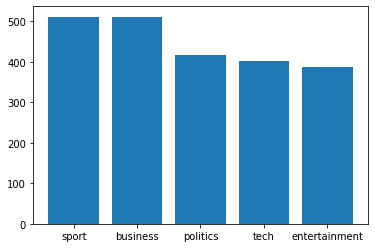

<IPython.core.display.Javascript object>

In [22]:
plt.bar(count_ser.index, count_ser)
plt.show()

In [23]:
# df["group"] = df["class"]

# df["group"] = preprocessing.LabelEncoder().fit_transform(df["group"])

<IPython.core.display.Javascript object>

In [24]:
# length of each text
df["char_cnt"] = df["content"].str.len()

# number of words in each text
df["word_cnt"] = df["content"].str.split().str.len()

# avg of each text
df["avg_word_length"] = df["char_cnt"] / df["word_cnt"]

df

,content,class,new_content,char_cnt,word_cnt,avg_word_length
0,Ad sales boost Time Warner profit. Quarterly p...,business,ad sales boost time warner profit quarterly pr...,2560,421,6.080760
1,Dollar gains on Greenspan speech. The dollar h...,business,dollar gains greenspan speech dollar hit highe...,2252,384,5.864583
2,Yukos unit buyer faces loan claim. The owners ...,business,yukos unit buyer faces loan claim owners embat...,1552,264,5.878788
3,High fuel prices hit BA's profits. British Air...,business,high fuel prices hit bas profits british airwa...,2412,406,5.940887
4,Pernod takeover talk lifts Domecq. Shares in U...,business,pernod takeover talk lifts domecq shares uk dr...,1570,265,5.924528
...,...,...,...,...,...,...
2220,BT program to beat dialler scams. BT is introd...,tech,bt program beat dialler scams bt introducing t...,2519,420,5.997619
2221,Spam e-mails tempt net shoppers. Computer user...,tech,spam emails tempt net shoppers computer users ...,2285,357,6.400560
2222,Be careful how you code. A new European direct...,tech,careful code new european directive could put ...,6282,1050,5.982857
2223,US cyber security chief resigns. The man makin...,tech,us cyber security chief resigns man making sur...,2316,379,6.110818


<IPython.core.display.Javascript object>

In [79]:
text = ""
for i in df[['new_content']].values:
    text += str(i[0])
    
stop_words = set(STOPWORDS)
wc = WordCloud(background_color="black", stopwords=stop_words, max_words=300)
wc.generate(text)



<IPython.core.display.Javascript object>

In [80]:
print("Một vài từ phổ biến và tần suất của nó")
wc.words_

Một vài từ phổ biến và tần suất của nó


{'game': 1.0,
 'time': 0.8880471380471381,
 'government': 0.8358585858585859,
 'first': 0.7424242424242424,
 'make': 0.6910774410774411,
 'firm': 0.648989898989899,
 'many': 0.6388888888888888,
 'last': 0.6304713804713805,
 'made': 0.6035353535353535,
 'film': 0.5993265993265994,
 'well': 0.5968013468013468,
 'added': 0.5917508417508418,
 'player': 0.5648148148148148,
 'world': 0.5589225589225589,
 'back': 0.5580808080808081,
 'take': 0.5555555555555556,
 'company': 0.531986531986532,
 'show': 0.515993265993266,
 'work': 0.5025252525252525,
 'good': 0.5008417508417509,
 'still': 0.4983164983164983,
 'number': 0.49242424242424243,
 'plan': 0.48148148148148145,
 'market': 0.4772727272727273,
 'come': 0.4772727272727273,
 'going': 0.4713804713804714,
 'think': 0.4604377104377104,
 'group': 0.4562289562289562,
 'play': 0.45454545454545453,
 'need': 0.45286195286195285,
 'sale': 0.44276094276094274,
 'service': 0.43097643097643096,
 'much': 0.41835016835016836,
 'part': 0.4166666666666667,


<IPython.core.display.Javascript object>

In [81]:
"""
từ biểu đồ, ta thấy có một vài từ không quan trọng nhưng có độ tần suất cao, và một vài từ không có ý nghĩa (đa phần là các từ có độ dài <3)
"""

'\ntừ biểu đồ, ta thấy có một vài từ không quan trọng nhưng có độ tần suất cao, và một vài từ không có ý nghĩa (đa phần là các từ có độ dài <3)\n'

<IPython.core.display.Javascript object>

In [82]:
# Loại bỏ các từ có 1 đến 3 chữ, và các từ không ý nghĩa gây nhiễu
df["new_content"] = (
    df["new_content"]
    .str.replace(r"(\b\w{1,3}\b)|said|people|say|year|want|told|best", "")
    .str.replace("\s{2,}", " ")
)

<IPython.core.display.Javascript object>

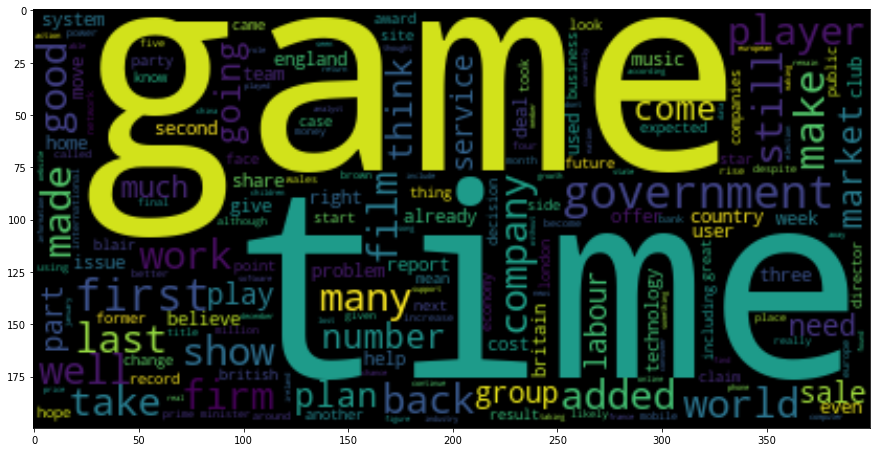

<IPython.core.display.Javascript object>

In [83]:
plt.figure(figsize=(15, 10))
plt.imshow(wc, interpolation="bilinear")
plt.show()

### Chuẩn bị dữ liệu train

In [84]:
# # vectorizer = CountVectorizer().fit_transform(df.content)
# vectorizer = CountVectorizer(min_df=0.05, stop_words="english").fit_transform(
#     df.content
# )
# # vectorizer = TfidfVectorizer(stop_words="english", max_features=200).fit_transform(df.content)

<IPython.core.display.Javascript object>

In [85]:
# X = vectorizer.toarray()

<IPython.core.display.Javascript object>

In [86]:
vectorizer = TfidfVectorizer(max_features=2000, stop_words="english")
matrix = vectorizer.fit_transform(df["new_content"]).toarray()
tfidf_df = pd.DataFrame(matrix, columns=vectorizer.get_feature_names())

<IPython.core.display.Javascript object>

In [87]:
X = tfidf_df.copy()

<IPython.core.display.Javascript object>

In [88]:
X

,ability,able,abroad,absolutely,academy,accept,accepted,access,according,account,...,wrote,xbox,yahoo,york,young,younger,youre,yugansk,yukos,zealand
0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.186662,...,0.000000,0.00000,0.0,0.11505,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.0,0.00000,0.0,0.000000,0.000000,0.494512,0.438033,0.0
3,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
4,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2220,0.0,0.054984,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2221,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2222,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.028105,0.000000,...,0.000000,0.00000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
2223,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.0,0.00000,0.0,0.000000,0.000000,0.000000,0.000000,0.0


<IPython.core.display.Javascript object>

In [89]:
X.shape

(2225, 2000)

<IPython.core.display.Javascript object>

### Áp dụng thuật toán thích hợp. Dựa trên cơ sở nào để cho rằng thuật toán này thích  hợp? 

## <p style="color:blue">Nhận xét</p>

In [36]:
"""
Với 3 thuật toán phân cụm là Kmeans, Hierachical và GMM
ta có thể đoán dc Hierachical không phù hợp với dataset này bằng Kmeans và GMM

Tuy nhiên, ta thử build cả 3 thuật toán để nhìn tổng quát hơn
"""

'\nVới 3 thuật toán phân cụm là Kmeans, Hierachical và GMM\nta có thể đoán dc Hierachical không phù hợp với dataset này bằng Kmeans và GMM\n\nTuy nhiên, ta thử build cả 3 thuật toán để nhìn tổng quát hơn\n'

<IPython.core.display.Javascript object>

### KMeans

In [37]:
# k means determine k
distortions = []
K = range(2, 8)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(
        sum(np.min(cdist(X, kmeanModel.cluster_centers_, "euclidean"), axis=1))
        / X.shape[0]
    )

<IPython.core.display.Javascript object>

In [38]:
distortions

[0.9768076469624667,
 0.9713052633654743,
 0.9661813731018367,
 0.9618319992675841,
 0.9585822517046328,
 0.9554531778199843]

<IPython.core.display.Javascript object>

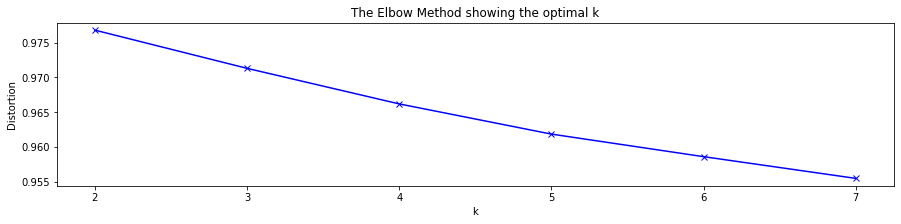

<IPython.core.display.Javascript object>

In [39]:
# Plot the elbow
plt.figure(figsize=(15, 3))
plt.plot(K, distortions, "bx-")
plt.xlabel("k")
plt.ylabel("Distortion")
plt.title("The Elbow Method showing the optimal k")
plt.show()

In [40]:
"""
Từ số liệu và đồ thị, ta chọn k = 5 vì từ 5, distribution giảm đi nhỏ và khá mịn (thật ra nhìn tổng thể các giá trị nó cầu trượt vậy :)))
"""

'\nTừ số liệu và đồ thị, ta chọn k = 5 vì từ 5, distribution giảm đi nhỏ và khá mịn (thật ra nhìn tổng thể các giá trị nó cầu trượt vậy :)))\n'

<IPython.core.display.Javascript object>

In [41]:
kmeans_model = KMeans(n_clusters=5)
kmeans_model = kmeans_model.fit(X)
centroids = kmeans_model.cluster_centers_
labels = kmeans_model.labels_
print(centroids)
print(labels)

[[ 7.20740720e-04  3.12300002e-03 -2.16840434e-18 ...  5.63785130e-18
   1.73472348e-18  6.65323170e-04]
 [ 6.01495751e-03  1.45132925e-02  4.88924982e-04 ...  5.85469173e-18
  -8.67361738e-18 -6.07153217e-18]
 [ 1.26951420e-03  5.85756638e-03  6.86179806e-04 ...  6.28837260e-18
   8.67361738e-18  9.33861261e-03]
 [ 1.61670111e-03  3.18722651e-03  2.63932050e-03 ...  7.02049986e-03
   2.24926458e-02  7.28713352e-04]
 [ 3.41020241e-03  6.61971154e-03  2.74966613e-03 ...  5.42101086e-18
   3.46944695e-18  5.30555326e-04]]
[3 3 3 ... 1 1 2]


<IPython.core.display.Javascript object>

In [42]:
df["kmeans_group"] = pd.Series(labels)
df.head()

,content,class,new_content,char_cnt,word_cnt,avg_word_length,kmeans_group
0,Ad sales boost Time Warner profit. Quarterly p...,business,sales boost time warner profit quarterly prof...,2560,421,6.080760,3
1,Dollar gains on Greenspan speech. The dollar h...,business,dollar gains greenspan speech dollar highest l...,2252,384,5.864583,3
2,Yukos unit buyer faces loan claim. The owners ...,business,yukos unit buyer faces loan claim owners embat...,1552,264,5.878788,3
3,High fuel prices hit BA's profits. British Air...,business,high fuel prices profits british airways blame...,2412,406,5.940887,3
4,Pernod takeover talk lifts Domecq. Shares in U...,business,pernod takeover talk lifts domecq shares drink...,1570,265,5.924528,3


<IPython.core.display.Javascript object>

In [43]:
### Trực quan biểu đồ = cách dùng PCA để giảm chiều

from sklearn.decomposition import PCA

principalComponents = PCA(n_components=2).fit_transform(X)
principalDf = pd.DataFrame(
    data=principalComponents, columns=["principal component 1", "principal component 2"]
)

vis_df = pd.concat([principalDf, df.kmeans_group], axis=1)

<IPython.core.display.Javascript object>

In [44]:
vis_df

,principal component 1,principal component 2,kmeans_group
0,0.030202,-0.232646,3
1,0.101820,-0.100102,3
2,0.022846,-0.080556,3
3,0.052413,-0.146390,3
4,0.035685,-0.129286,3
...,...,...,...
2220,0.020799,-0.182088,1
2221,0.015196,-0.130936,1
2222,0.075995,-0.069780,1
2223,0.020678,-0.068390,1


<IPython.core.display.Javascript object>

### Tìm kết quả => có bao nhiêu cụm => mẫu (tin tức) nào thuộc cụm nào? 

### Dùng PCA để trực quan hóa

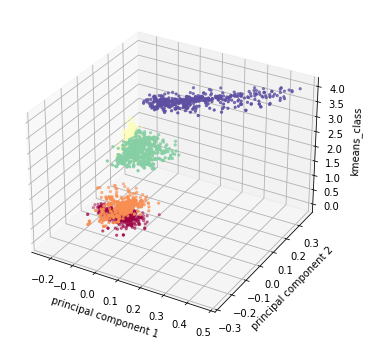

<IPython.core.display.Javascript object>

In [45]:
# 3 chiều
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    vis_df["principal component 1"],
    vis_df["principal component 2"],
    vis_df["kmeans_group"],
    c=vis_df["kmeans_group"],
    marker=".",
    cmap=plt.cm.Spectral,
)
ax.set_xlabel("principal component 1")
ax.set_ylabel("principal component 2")
ax.set_zlabel("kmeans_class")
# plt.scatter(centroids[:, 0], centroids[:, 1], c="red", s=300, alpha=0.6)

plt.show()

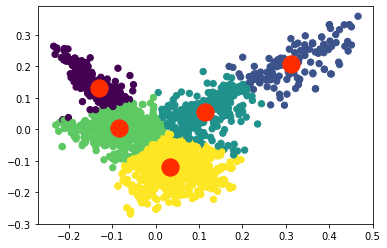

<IPython.core.display.Javascript object>

In [46]:
# 2 chiều
sklearn_pca = PCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X)
test_e = KMeans(n_clusters=5, max_iter=1200, algorithm="auto")
fitted = test_e.fit(Y_sklearn)
predicted_values = test_e.predict(Y_sklearn)
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=40, cmap="viridis")
centroids = fitted.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    c="#FF2C00",
    s=300,
)
plt.show()

## <p style="color:blue">Nhận xét</p>

In [47]:
"""
dữ liệu phân khá rõ thành 5 cụm
=> Kmeans phù hợp với dataset này

"""

'\ndữ liệu phân khá rõ thành 5 cụm\n=> Kmeans phù hợp với dataset này\n\n'

<IPython.core.display.Javascript object>

In [48]:
df["kmeans_group"].value_counts()

2    542
3    533
1    397
4    389
0    364
Name: kmeans_group, dtype: int64

<IPython.core.display.Javascript object>

In [49]:
"""
phân bố giữa các nhóm khá đều nhau
"""

'\nphân bố giữa các nhóm khá đều nhau\n'

<IPython.core.display.Javascript object>

### GMM

In [50]:
from sklearn import metrics

list_sil = []
K = range(2, 8)
for k in K:
    gmm = GaussianMixture(n_components=k)
    gmm.fit(X)
    labels = gmm.predict(X)
    sil = metrics.silhouette_score(X, labels, metric="euclidean")
    list_sil.append(sil)

<IPython.core.display.Javascript object>

In [51]:
list_sil

[0.012577591027654182,
 0.013139225176644813,
 0.015876482429436477,
 0.02158847459213214,
 0.022241298900570108,
 0.01995150830464893]

<IPython.core.display.Javascript object>

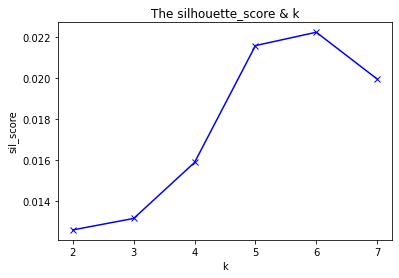

<IPython.core.display.Javascript object>

In [52]:
# Plot
plt.plot(K, list_sil, "bx-")
plt.xlabel("k")
plt.ylabel("sil_score")
plt.title("The silhouette_score & k")
plt.show()

In [53]:
"""
=> lần lượt build model với k = 7, 6, 5
"""

'\n=> lần lượt build model với k = 7, 6, 5\n'

<IPython.core.display.Javascript object>

[[ 0.06338728  0.03472503]
 [ 0.0456591  -0.14821711]
 [ 0.34411377  0.21626306]
 [-0.1138239   0.11209113]
 [ 0.16792267  0.10968616]
 [-0.10161379 -0.00225791]
 [ 0.01348341 -0.08431889]]


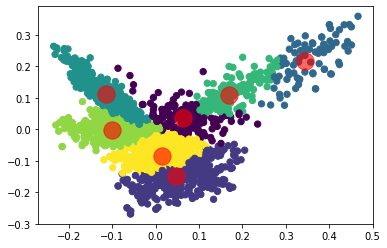

<IPython.core.display.Javascript object>

In [54]:
# build với k = 7
sklearn_pca = PCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X)
gmm = GaussianMixture(n_components=7, max_iter=1500, random_state=1)

fitted = gmm.fit(Y_sklearn)
print(gmm.means_)
predicted_values = fitted.predict(Y_sklearn)
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=40, cmap="viridis")
plt.figsize = (12, 8)
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], color="red", s=300, alpha=0.6)
plt.show()

In [92]:
"""
k = 7 cho phân cụm khá rõ rệt
"""

'\nk = 7 cho phân cụm khá rõ rệt\n'

<IPython.core.display.Javascript object>

[[ 0.11412792  0.06342671]
 [ 0.00395921 -0.13204092]
 [-0.09312281  0.00514094]
 [ 0.30687593  0.19653009]
 [-0.11800559  0.11764483]
 [ 0.04760858 -0.09666584]]


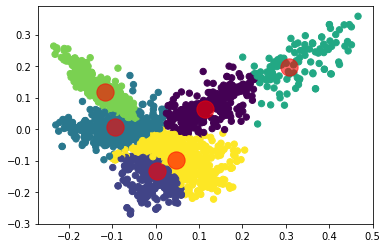

<IPython.core.display.Javascript object>

In [56]:
# build với k = 6
sklearn_pca = PCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X)
gmm = GaussianMixture(n_components=6, max_iter=1500, random_state=1)

fitted = gmm.fit(Y_sklearn)
print(gmm.means_)

predicted_values = fitted.predict(Y_sklearn)
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=40, cmap="viridis")
plt.figsize = (12, 8)
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], color="red", s=300, alpha=0.6)
plt.show()

In [93]:
"""
Nhận xét: với k = 6 cũng cho phân cụm rõ
"""

'\nNhận xét: với k = 6 cũng cho phân cụm rõ\n'

<IPython.core.display.Javascript object>

[[ 0.10464664  0.05378347]
 [ 0.03038147 -0.11403123]
 [-0.09062246  0.00466608]
 [ 0.29305179  0.18872395]
 [-0.11814937  0.11789382]]


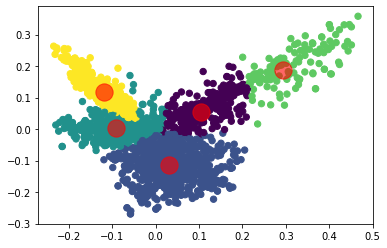

<IPython.core.display.Javascript object>

In [58]:
# build với k = 5
sklearn_pca = PCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X)
gmm = GaussianMixture(n_components=5, max_iter=1500, random_state=1)

fitted = gmm.fit(Y_sklearn)
print(gmm.means_)

predicted_values = fitted.predict(Y_sklearn)
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=predicted_values, s=40, cmap="viridis")
plt.figsize = (12, 8)
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], color="red", s=300, alpha=0.6)
plt.show()

In [94]:
"""
Nhận xét: với k = 5, các điểm dữ liệu phân chia theo cụm ổn.
"""

'\nNhận xét: với k = 5, các điểm dữ liệu phân chia theo cụm ổn.\n'

<IPython.core.display.Javascript object>

In [95]:
"""
Dường như, GMM phù hợp với dataset này, có thể chọn k = 5 hoặc = 6 hoặc k = 7 đều dc
Tuy nhiên, k = 5 cho sự phân cụm đẹp hơn

"""

'\nDường như, GMM phù hợp với dataset này, có thể chọn k = 5 hoặc = 6 hoặc k = 7 đều dc\nTuy nhiên, k = 5 cho sự phân cụm đẹp hơn\n\n'

<IPython.core.display.Javascript object>

### Hierachical

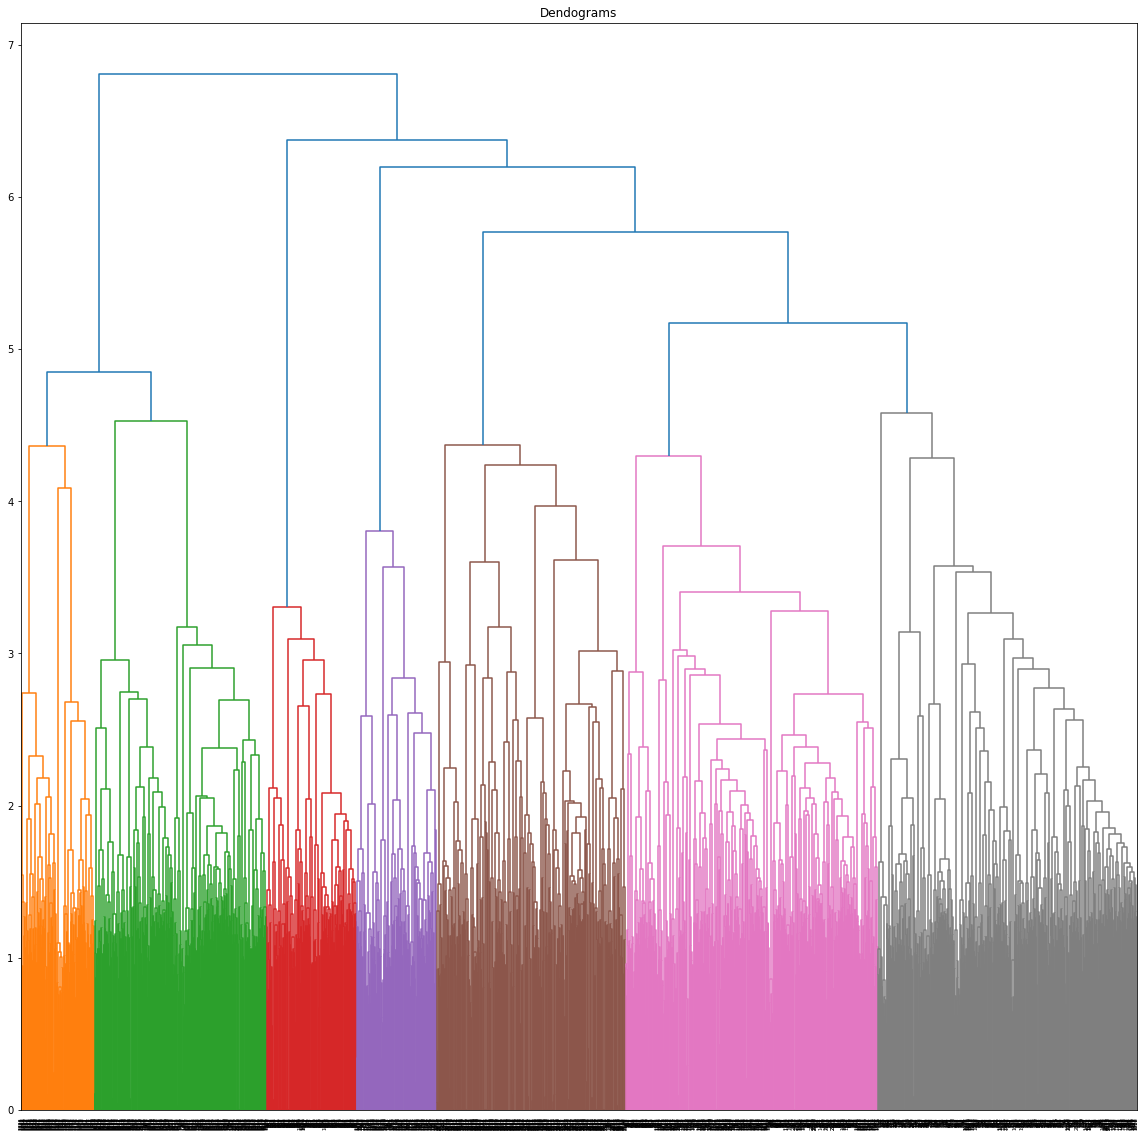

<IPython.core.display.Javascript object>

In [90]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(20, 20))
plt.title("Dendograms")
dend = shc.dendrogram(shc.linkage(X, method="ward"))

In [62]:
'''
Dựa vào Dendograms, chúng ta sẽ chọn k = 7 cho thuật toán hierachical
'''


'\nDựa vào Dendograms, chúng ta sẽ chọn k = 5 cho thuật toán hierachical\n'

<IPython.core.display.Javascript object>

In [63]:
hierachical_model = AgglomerativeClustering(n_clusters=5, affinity="euclidean").fit(X)

<IPython.core.display.Javascript object>

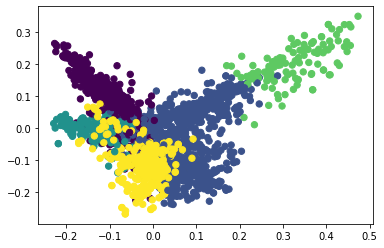

<IPython.core.display.Javascript object>

In [91]:
sklearn_pca = PCA(n_components=7)
Y_sklearn = sklearn_pca.fit_transform(X)
fitted = hierachical_model.fit(Y_sklearn)
plt.scatter(
    Y_sklearn[:, 0], Y_sklearn[:, 1], c=hierachical_model.labels_, s=40, cmap="viridis"
)

plt.show()

In [65]:
"""
các điểm dữ liệu vẫn bị nằm đè lên nhau

=> hierachical_model có vẻ không phù hợp với dataset này
"""

'\ncác điểm dữ liệu vẫn bị nằm đè lên nhau\n\n=> hierachical_model có vẻ không phù hợp với dataset này\n'

<IPython.core.display.Javascript object>

## Đánh giá

In [66]:
"""
Từ 3 thuật toán trên, ta thấy Kmeans và GMM là phù hợp nhất với dataset. 
Hierachical tỏ ra yếu thế với dataset có số lượng features lớn

Ở đây, em chọn KMeans để thực hiện đánh giá.
"""

'\nTừ 3 thuật toán trên, ta thấy Kmeans và GMM là phù hợp nhất với dataset. \nHierachical tỏ ra yếu thế với dataset có số lượng features lớn\n\nỞ đây, em chọn KMeans để thực hiện đánh giá.\n'

<IPython.core.display.Javascript object>

### Nhận xét trên từng cụm: mỗi cụm có những keywords nào ? Vẽ WordClouds cho từng cụm. 

In [96]:
df_count = df.kmeans_group.value_counts()
df_count

2    542
3    533
1    397
4    389
0    364
Name: kmeans_group, dtype: int64

<IPython.core.display.Javascript object>

## <p style="color:blue">Nhận xét</p>

In [119]:
"""
Nhóm 2 có 542
Nhóm 3 có 533
Nhóm 1 có 397
Nhóm 4 có 389
Nhóm 0 có 364
=> dữ liệu phân bố khá đều giữa các nhóm, ko bị mất cân bằng
"""

'\nNhóm 2 có 542\nNhóm 3 có 533\nNhóm 1 có 397\nNhóm 4 có 389\nNhóm 0 có 364\n=> dữ liệu phân bố khá đều giữa các nhóm, ko bị mất cân bằng\n'

<IPython.core.display.Javascript object>

In [69]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs



<IPython.core.display.Javascript object>

In [70]:
def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(
            ("Most Common Words in Cluster {}".format(i)),
            fontsize=10,
            fontweight="bold",
        )
        sns.barplot(x="score", y="features", orient="h", data=dfs[i][:n_feats])
        plt.show()

<IPython.core.display.Javascript object>

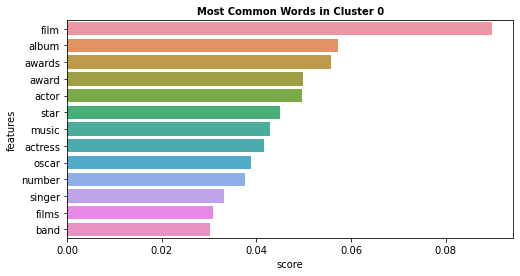

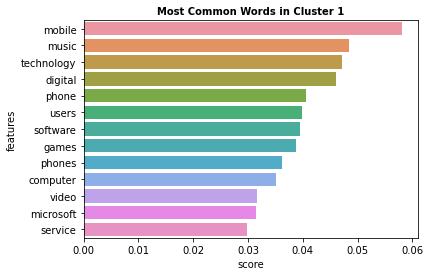

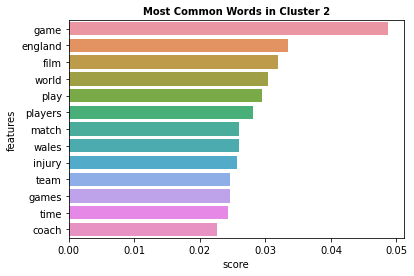

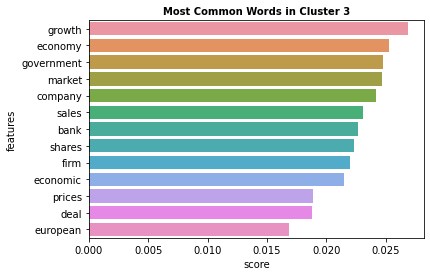

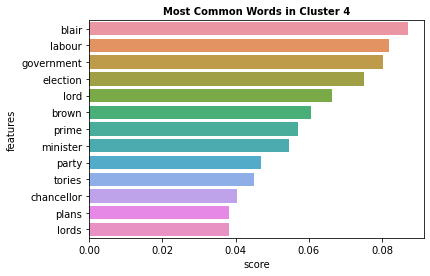

<IPython.core.display.Javascript object>

In [97]:
df_final = X
df_final_array = df_final.to_numpy()
prediction = kmeans_model.predict(df_final)
n_feats = 20
dfs = get_top_features_cluster(df_final_array, prediction, n_feats)
plotWords(dfs, 13)

In [98]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending=False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update({a[i, 0]: a[i, 1]})

    return centroid_dict


def generateWordClouds(centroids):
    wordcloud = WordCloud(max_font_size=100, background_color="black")
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)
        wordcloud.generate_from_frequencies(centroid_dict)

        plt.figure()
        plt.title("Cluster {}".format(i))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.show()

<IPython.core.display.Javascript object>

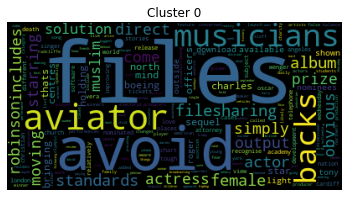

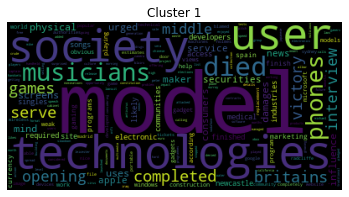

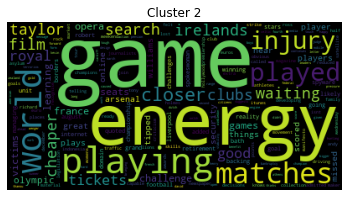

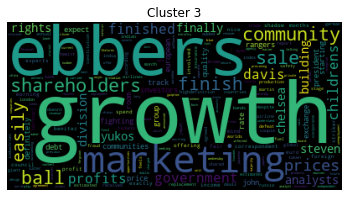

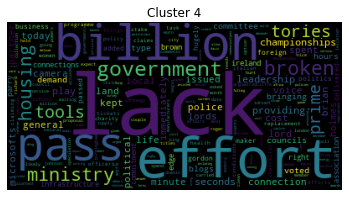

<IPython.core.display.Javascript object>

In [100]:
centroids = pd.DataFrame(kmeans_model.cluster_centers_)
centroids.columns = df_final.columns
generateWordClouds(centroids)

### Kiểm chứng lại so với Class đã có

In [111]:
# df[df["class"] == "sport"]
# df

<IPython.core.display.Javascript object>

In [112]:
df["group"] = df["class"].replace(
    {"entertainment": 0, "business": 3, "politics": 4, "tech": 1, "sport": 2}
)

<IPython.core.display.Javascript object>

In [113]:
y_test = df["group"]
y_hat_test = df["kmeans_group"]

<IPython.core.display.Javascript object>

In [114]:
y_hat_test

0       3
1       3
2       3
3       3
4       3
       ..
2220    1
2221    1
2222    1
2223    1
2224    2
Name: kmeans_group, Length: 2225, dtype: int32

<IPython.core.display.Javascript object>

In [115]:
y_test

0       3
1       3
2       3
3       3
4       3
       ..
2220    1
2221    1
2222    1
2223    1
2224    1
Name: group, Length: 2225, dtype: int64

<IPython.core.display.Javascript object>

In [116]:
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion_matrix:\n")
print(confusion_matrix(y_test, y_hat_test))
target_names = ["Business", "Tech", "Entertainment", "Politics", "Sport"]
print(classification_report(y_test, y_hat_test, target_names=target_names))

Confusion_matrix:

[[356  12   7  10   1]
 [  5 369  19   7   1]
 [  1   0 509   1   0]
 [  1  10   1 493   5]
 [  1   6   6  22 382]]
               precision    recall  f1-score   support

     Business       0.98      0.92      0.95       386
         Tech       0.93      0.92      0.92       401
Entertainment       0.94      1.00      0.97       511
     Politics       0.92      0.97      0.95       510
        Sport       0.98      0.92      0.95       417

     accuracy                           0.95      2225
    macro avg       0.95      0.94      0.95      2225
 weighted avg       0.95      0.95      0.95      2225



<IPython.core.display.Javascript object>

## <p style="color:blue">Nhận xét</p>

In [118]:
"""
Sau khi kiểm chứng lại so với class ban đầu,
accuracy lên tới 95%; precision, recall, f1-score của các nhóm đều cao

Tùy vào ý nghĩa của dữ liệu mà việc phân cụm mang các ý nghĩa khác nhau do bài toán về clustering không có phân cụm đúng hay sai!

Tuy nhiên, việc kmeans phân cụm lại rất sát với giá trị thực.
"""

'\nSau khi kiểm chứng lại so với class ban đầu,\naccuracy lên tới 95%; precision, recall, f1-score của các nhóm đều cao\n\nTùy vào ý nghĩa của dữ liệu mà việc phân cụm mang các ý nghĩa khác nhau do bài toán về clustering không có phân cụm đúng hay sai!\n\nTuy nhiên, việc kmeans phân cụm lại rất sát với giá trị thực.\n'

<IPython.core.display.Javascript object>